---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [23]:
from abc import ABCMeta
from abc import abstractproperty
import operator
import re

import pandas
import numpy
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [24]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [25]:
COLUMN_AXIS = 1 
DEBUG = True
UNIVERSITY_TOWNS_DATA = "university_towns.txt"
GDP_DATA = "gdplev.xls"

In [26]:
class BaseData(object):
    """Base class for the data-loaders
    
    Parameters
    ----------

    settings: object
       holder of settings needed to load the data
    """
    __meta__ = ABCMeta
    def __init__(self, settings):
        self.settings = settings
        self._data = None
        return

    @abstractproperty
    def data(self):
        """the data-frame"""
        return

In [27]:
class UniversitySettings(object):
    """settings for the UniversityData"""
    source = UNIVERSITY_TOWNS_DATA
    state_substring = "[edit]"
    state_split = "["
    region_split = " ("
    columns = ["State", "RegionName"]

In [28]:
class UniversityData(BaseData):
    """builder of the data"""

    @property
    def data(self):
        """the data-frame with university state/regions"""
        if self._data is None:
            lines = []
            with open(self.settings.source) as data:
                for line in data:
                    if self.settings.state_substring in line:
                        state = line.split(self.settings.state_split)[0].strip()
                    else:
                        region = line.split(self.settings.region_split)[0].strip()
                        lines.append([state, region])
            self._data = pandas.DataFrame(lines, columns=self.settings.columns)
        return self._data

In [29]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    builder = UniversityData(UniversitySettings)
    return builder.data

In [30]:
output = get_list_of_university_towns()
assert output[output.RegionName.str.startswith("Ann Arbor")].State.iloc[0] == "Michigan"
assert output[output.RegionName.str.startswith("Ypsilanti")].State.iloc[0] == "Michigan"
if DEBUG:
    print(output[output.State.str.startswith("Michigan")])

        State        RegionName
194  Michigan            Adrian
195  Michigan            Albion
196  Michigan         Allendale
197  Michigan              Alma
198  Michigan         Ann Arbor
199  Michigan   Berrien Springs
200  Michigan        Big Rapids
201  Michigan      East Lansing
202  Michigan             Flint
203  Michigan         Hillsdale
204  Michigan          Houghton
205  Michigan         Kalamazoo
206  Michigan         Marquette
207  Michigan           Midland
208  Michigan    Mount Pleasant
209  Michigan            Olivet
210  Michigan           Saginaw
211  Michigan  Sault Ste. Marie
212  Michigan      Spring Arbor
213  Michigan         Ypsilanti


In [31]:
def debug():
    df = get_list_of_university_towns()
    cols = ["State", "RegionName"]
    
    assert df.shape == (517, 2), "Shape Test Failed"
    print('Shape test: Passed')
    assert df.index.tolist() == list(range(517)), "Index Test Failed"
    print('Index test: ', "Passed")
    
    assert df.columns.tolist() == cols, "Column Test Failed"
    print('Column test: Passed')
    assert not (any(df[cols[0]].str.contains('\n')) or\
                any(df[cols[1]].str.contains('\n'))), "\\n test Failed"
    print('\\n test: Passed')
    assert not (any(df[cols[0]].str.contains(
        '\s+$')) or any(df[cols[1]].str.contains(
            '\s+$'))), "Trailing Whitespace test Failed"
    print('Trailing whitespace test: Passed')
    print('"(" test:',
          "Failed" if any(df[cols[0]].str.contains(
              '\(')) or any(df[cols[1]].str.contains(
                  '\('))
          else 'Passed')
    print('"[" test:',
          "Failed" if any(df[cols[0]].str.contains(
              '\[')) or any(df[cols[1]].str.contains(
                  '\]'))
          else 'Passed')
    # from troubleshooting learners code, using incorrect regex
    # for RegionName usually generates these common mismatches
    rgn_rgx_mstch = [
        'Pomona', 'Mankato', 'Fulton', 'Sewanee']
    rgn_loc = (33, 218, 237, 442)
    print ('RegionName regex test: ', "Passed" if all(df.loc[
        rgn_loc, 'RegionName'] == rgn_rgx_mstch)
           else "Failed")
    # when using split or find to extract regionName, these are
    # common mismatches
    rgn_splt_msmtch = [
        'The Five College Region of Western Massachusetts:',
        'Faribault, South Central College']
    rgn_loc = (184, 217)
    print ('RegionName regex test: ', "Passed" if all(df.loc[
        rgn_loc, 'RegionName'] == rgn_splt_msmtch)
           else "Failed")
    #test if . was  inadvertently removed
    print('RegionName regex test:',"Passed" if any(df[cols[1]].str.contains(
        '\.')) else "Failed")
    # use the values of the states dictionary precoded to verify
    # state names are as expected
    states_vlist = list(sorted(states.values()))
    mismatchedStates = df[~df['State'].isin(
        states_vlist)].loc[:, 'State'].unique()
    print ('State regex test: ', "Passed" if len(
        mismatchedStates) == 0 else "Failed")
    if len(mismatchedStates) > 0:
        print()
        print('The following states failed the equality test:')
        print()
        print('\n'.join(mismatchedStates))
        return

if DEBUG:
    debug()

Shape test: Passed
Index test:  Passed
Column test: Passed
\n test: Passed
Trailing whitespace test: Passed
"(" test: Passed
"[" test: Passed
RegionName regex test:  Passed
RegionName regex test:  Passed
RegionName regex test: Passed
State regex test:  Passed


In [32]:
class GDPSettings(object):
    """holder of settings to load and clean the data"""
    source = GDP_DATA
    skip_rows = 8
    columns = ["Year", "Annual GDP Current Billions",
               "Annual GDP 2009 Billions", "to_delete", "YearQuarter",
               "Quarterly GDP Current Billions", "Quarterly GDP 2009 Billions",
               "to_delete"]
    quarterly_column = "Quarterly GDP 2009 Billions"
    first_quarter = "2000q1"
    delete_columns = "to_delete"

In [33]:
class GDPData(BaseData):
    """GDP Data Loader and cleaner"""
    @property
    def data(self):
        if self._data is None:
            self._data = pandas.read_excel(self.settings.source,
                                           skiprows=self.settings.skip_rows,
                                           names=self.settings.columns)
            self._data = self._data.drop(self.settings.delete_columns,
                                         axis=COLUMN_AXIS)
            return self._data

<IPython.core.display.Javascript object>


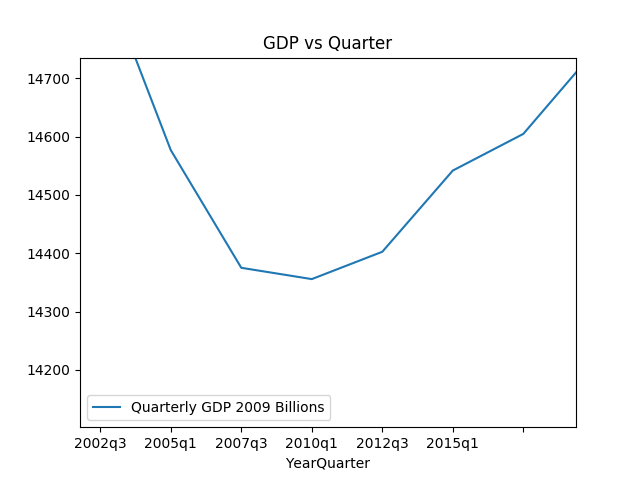

In [34]:
if DEBUG:
    % matplotlib notebook
    #import seaborn
    #seaborn.set_style('whitegrid')
    data = GDPData(GDPSettings).data
    data = data.iloc[data[data.YearQuarter==GDPSettings.first_quarter].index[0]:]
    axis = data.plot(x="YearQuarter", y=GDPSettings.quarterly_column)
    axis.set_title("GDP vs Quarter")    

In [35]:
def get_later_data():
    """
    Returns
    -------

    DataFrame: GDP data from 2000 q1
    """
    data = GDPData(GDPSettings).data
    data = data.iloc[data[data.YearQuarter==GDPSettings.first_quarter].index[0]:]
    return data.dropna(COLUMN_AXIS).reset_index()

In [36]:
def recession_index(data, compare=operator.gt):
    """returns the index of the start of the recession

    Parameters
    ----------
    data: DataFrame
       GDP data to search

    compare: function
       compare quarters (change to < to find end)

    Returns
    -------

    int : iloc of start of first recession found
    """
    for index, gdp in enumerate(data[GDPSettings.quarterly_column]):
        next_gdp = data[GDPSettings.quarterly_column].iloc[index + 1]
        if (index != 0 and
            (compare(data[GDPSettings.quarterly_column].iloc[index - 1],
                     gdp) and compare(gdp, next_gdp))):
            return index
        elif (compare(gdp, next_gdp) and 
              compare(next_gdp, data[GDPSettings.quarterly_column].iloc[index + 2])):
            return index + 1
    return

In [37]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    data = get_later_data()
    index = recession_index(data)
    return data.YearQuarter.iloc[index]

if DEBUG:
    print(get_recession_start())

2008q3


In [38]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    data = get_later_data()
    start = get_recession_start()
    data = data[data[data.YearQuarter==start].index[0]:]
    index = recession_index(data, operator.lt) + 1
    return data.YearQuarter.iloc[index]

if DEBUG:
    print(get_recession_end())

2009q4


In [47]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    data = get_later_data()
    start = get_recession_start()
    end = get_recession_end()
    data = data[data[data.YearQuarter==start].index[0]:
                data[data.YearQuarter==end].index[0]]
    return data.YearQuarter.loc[data[GDPSettings.quarterly_column].argmin()]
if DEBUG:
    print(get_recession_bottom())

2009q2


<IPython.core.display.Javascript object>


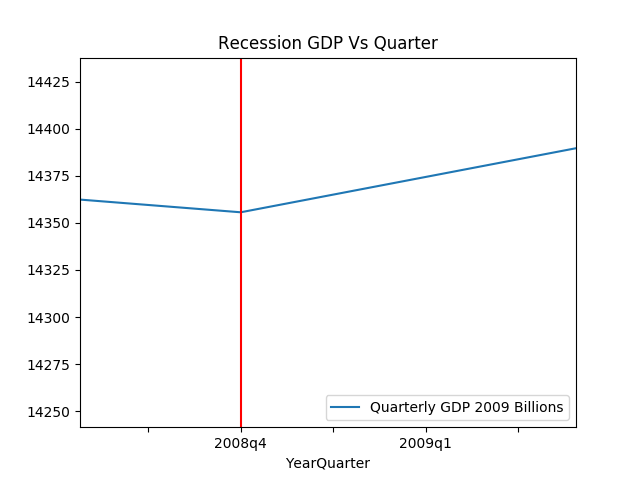

In [48]:
start = get_recession_start()
bottom = get_recession_bottom()
end = get_recession_end()

data = get_later_data()
data = data[data[data.YearQuarter==start].index[0]:
            data[data.YearQuarter==end].index[0]]
line = [data[GDPSettings.quarterly_column].min(),
        data[GDPSettings.quarterly_column].max()]
axis = data.plot(x="YearQuarter", y=GDPSettings.quarterly_column)
axis.axvline([3], color='r')
axis.set_title("Recession GDP Vs Quarter")

In [40]:
class HousingSettings(object):
    """holds the settings for the housing data"""
    source = "City_Zhvi_AllHomes.csv"
    years = ["20{0:02d}".format(year) for year in range(17)]
    year_month_pattern = re.compile("20\d\d-\d\d")
    quarters = [re.compile("|".join(["{0:02d}".format(month)
                                     for month in range(start, start+3)]))
                for start in range(1, 11, 3)]

In [41]:
class HousingData(BaseData):
    """loads the housing data"""
    @property
    def data(self):
        """
        Returns
        -------

        DataFrame: frame with the zillow housing data
        """
        if self._data is None:
            self._data = pandas.read_csv(self.settings.source)
            self._data.State = self._data.State.map(lambda x: states[x])
            quarters = self.convert_quarters(self._data)
            tuples = [self._data.State, self._data.RegionName]
            multi_index = pandas.MultiIndex.from_tuples(list(zip(*tuples)),
                                                        names=["State", "RegionName"])
            self._data = quarters.set_index(multi_index)
        return self._data

    def convert_quarters(self, data):
        """creates a data-frame with the data as means of quarters

        Parameters
        ----------

        data: DataFrame
          Housing Data
        
        Returns
        -------

        DataFrame: month columns from data converted to means of quarters
        """
        all_years = data.select(lambda x: self.settings.year_month_pattern.match(x),
                                axis=COLUMN_AXIS)
        means = {}
        for year_label in self.settings.years:
            year = all_years.select(lambda x: re.search(year_label, x),
                                    axis = COLUMN_AXIS)
            for index, quarter_regex in enumerate(self.settings.quarters):
                quarter = year.select(lambda x: quarter_regex.search(x),
                                      axis=COLUMN_AXIS)
                means["{0}q{1}".format(year_label, index+1)] = quarter.mean(axis=COLUMN_AXIS)
        return pandas.DataFrame(means).dropna(axis="columns", how="all")


In [42]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    housing = HousingData(HousingSettings)
    return housing.data

if DEBUG:
    outcome = convert_housing_data_to_quarters()
    assert outcome.shape == (10730, 67)

In [43]:
class TTest(object):
    """settings for the t-test"""
    price_ratio = "PriceRatio"
    intersection = "inner"
    merge_columns = UniversitySettings.columns
    threshold = 0.01
    university_town = "university town"
    non_university_town = "non-university town"

In [44]:
class HypothesisTester(object):
    """t-tester comparing university and non-university towns
    """
    def __init__(self):
        self._start = None
        self._bottom = None
        self._housing_data = None
        self._price_ratios = None
        self._university_towns = None
        self._university_price_ratios = None
        self._non_university_price_ratios = None
        self._p_value = None
        self._t_statistic = None
        self._better = None
        return

    @property
    def university_data(self):
        """the data for university towns"""
        if self._university_data is None:
            self._university_data = UniversityData(UniversitySettings).data
        return self._university_data

    @property
    def start(self):
        """start of the recession

        Returns
        -------

        String: column name of the start of the recession
        """
        if self._start is None:
            self._start = get_recession_start()
        return self._start

    @property
    def bottom(self):
        """nadir of the recession

        Returns
        -------

        String: column name of the bottom of the recession
        """
        if self._bottom is None:
            self._bottom = get_recession_bottom()
        return self._bottom

    @property
    def housing_data(self):
        """housing data

        Returns
        -------

        DataFrame: housing data with quarter-means
        """
        if self._housing_data is None:
            self._housing_data = convert_housing_data_to_quarters()
        return self._housing_data

    @property
    def university_towns(self):
        """The university towns
        """
        if self._university_towns is None:
            self._university_towns = get_list_of_university_towns()
        return self._university_towns

    @property
    def price_ratios(self):
        """ratios of start to bottom of recession prices

        Moves the index to columns so it can be merged

        Returns
        -------

        DataFrame: price-ratios
        """
        if self._price_ratios is None:
            # div returns a series
            self._price_ratios = self.housing_data[self.start].div(
                self.housing_data[self.bottom])            
            self._price_ratios = pandas.DataFrame(
                {TTest.price_ratio: self._price_ratios})
            self._price_ratios.reset_index(inplace=True)
        return self._price_ratios

    @property
    def university_price_ratios(self):
        """price ratios for university towns"""
        if self._university_price_ratios is None:
            self._university_price_ratios = pandas.merge(self.price_ratios,
                                                         self.university_towns,
                                                         how=TTest.intersection,
                                                         on=TTest.merge_columns)
            self._university_price_ratios.dropna(inplace=True)
        return self._university_price_ratios

    @property
    def non_university_price_ratios(self):
        """price-ratios for non-university towns"""
        if self._non_university_price_ratios is None:
            university_towns = (self.price_ratios.State.isin(
                self.university_price_ratios.State) &
                                (self.price_ratios.RegionName.isin(
                                    self.university_price_ratios.RegionName)))
            self._non_university_price_ratios = self.price_ratios[~university_towns]
            self._non_university_price_ratios = self._non_university_price_ratios.dropna()
        return self._non_university_price_ratios

    @property
    def p_value(self):
        """probability university/non-university price-ratios are the same

        as a side-effect also sets self._t_statistic

        Returns
        -------

        float: p-value based on a two-tailed t-test
        """
        if self._p_value is None:
            self._t_statistic, self._p_value = ttest_ind(
                self.university_price_ratios.PriceRatio.values,
                self.non_university_price_ratios.PriceRatio.values)
        return self._p_value

    @property
    def better(self):
        """identity of type of town that did better in the recession

        Returns
        -------

        string: university or non-university
        """
        if self._better is None:
            # since the denominator if the ratio is the bottom
            # of the recession, the lower the price ratio, the
            # less value was lost, so the better it did
            self._better = (
                TTest.university_town if
                self.university_price_ratios.PriceRatio.mean() <
                self.non_university_price_ratios.PriceRatio.mean() else
                TTest.non_university_town)
        return self._better

In [45]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    tester = HypothesisTester()
    different = tester.p_value < TTest.threshold
    return (different, tester.p_value, tester.better)

if DEBUG:
    print(run_ttest())

(True, 0.0032549086783324882, 'university town')


In [46]:
def check_ttest():
    res = run_ttest()
    print('Type test:', 'Passed' if type(res) == tuple else 'Failed')
    print('test `better` item type:','Passed' if type(res[0]) == bool or type(res[0]) == numpy.bool_ else 'Failed' )
    print('`p` item type test:', 'Passed' if type(
        res[1]) == numpy.float64 else 'Failed')
    print('`different` item type test:',
          'Passed' if type(res[2]) == str else 'Failed')
    print('`different` item spelling test:', 'Passed' if res[2] in [
        "university town", "non-university town"] else 'Failed')
    return

if DEBUG:
    check_ttest()

Type test: Passed
test `better` item type: Passed
`p` item type test: Passed
`different` item type test: Passed
`different` item spelling test: Passed
